#  SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we are replicating (the source of the dataset that we'll be using) is available here : https://arxiv.org/abs/1710.06071

If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHib: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

 ## Get data

 Since we'll be replicating the paper above ( PubMed 200k RCT), lets download the dataset they used

 We can do so from the authors Github: https://github.com/Franck-Dernoncourt/pubmed-rct

 



In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
%ls pubmed-rct

Cloning into 'pubmed-rct'...
Updating files:  76% (10/13)
Updating files:  84% (11/13)
Updating files:  92% (12/13)
Updating files: 100% (13/13)
Updating files: 100% (13/13), done.


 Volume in drive C has no label.
 Volume Serial Number is B2AA-FBB6

 Directory of C:\Users\a\Documents\GitHub\SkimLit\pubmed-rct

10-12-2021  15:52    <DIR>          .
10-12-2021  15:52    <DIR>          ..
10-12-2021  15:52    <DIR>          PubMed_200k_RCT
10-12-2021  15:52    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
10-12-2021  15:52    <DIR>          PubMed_20k_RCT
10-12-2021  15:52    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
10-12-2021  15:52             2,403 README.md
               1 File(s)          2,403 bytes
               6 Dir(s)  440,236,290,048 bytes free


In [3]:
# Check what files are in the PubMed_20K dataset
# %ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

%ls "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

 Volume in drive C has no label.
 Volume Serial Number is B2AA-FBB6

 Directory of C:\Users\a\Documents\GitHub\SkimLit\pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign

10-12-2021  15:52    <DIR>          .
10-12-2021  15:52    <DIR>          ..
10-12-2021  15:52         4,880,409 dev.txt
10-12-2021  15:52         4,846,504 test.txt
10-12-2021  15:52        29,118,832 train.txt
               3 File(s)     38,845,745 bytes
               2 Dir(s)  440,243,896,320 bytes free


In [4]:
# Start our experiments using the 20K dataset with numbers replaced by '@' sign
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, its time to become one with it.

And one of the best ways to become one with the data is to ...
> Visualize, Visualize, Visualize

So with that in mind, lets write a function to read in all of the lines of a target tesx file


In [6]:
# Create function to read the lines of a document

def get_lines(filenames):
    """
    Reads filename (a text file) and returns the lines of text as a list.
    
    Args:
        filename: a string containing the target filepath to read.
    
    Returns:
        A list of strings with one string per line from the target filename.
        For example:
        ["this is the first line of filename",
        "this is the second line of filename",
        "..."]
    """

    with open(filenames,'r') as f:
      return f.readlines()

In [7]:
# Lets read in the training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Lets think how we want our data to look...

How I think our data would be best represented

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': "to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .",
  'total_lines': 11},
  ...]
  ```

Lets write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """

  input_lines = get_lines(filename)
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith('###'): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string if the line is an id line

    elif line.isspace(): # Check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines


      # Iterate through each line in abstract and count them at the same time

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # Create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list


    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [12]:
# Get data from file and preprocess it

## %%time shows the time duration of the cell
%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))



Wall time: 0 ns
180040 30212 30135


In [13]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it

In [14]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

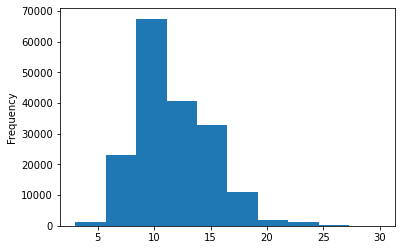

In [16]:
# Lets check the length of different lines
train_df.total_lines.plot.hist();


Get lists of sentences¶

In [17]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)



In [19]:
# One hot encode labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # We want non-sparse matrix (sparse=True will compress all the zeros to save memory)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1)) # here reshape(-1,1) means keep the 1st dimension same and add an extra one after that. eg for 5 it will become (5,1)
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1)) # Here we do not fit_transform because it is already fit once on train labels
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))


# Check what one hot encoderd labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
import tensorflow as tf
tf.constant(train_labels_one_hot)
#Tensorflow is incompitable with a sparse matrix. That is why we set sparse=False

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [21]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_) # To get the class names of the encoded vector
class_names = label_encoder.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a series of model experiments

We're going to start with a baseline(TF-IDF Multinomial Naive Bayes classifier)


## Model 0: Getting a baseline

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf",TfidfVectorizer()),
  ("clf", MultinomialNB())                  
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [24]:
# Evaluate the baseline model on the validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [25]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

Download helper functions used by Daniel Bourke
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [28]:
!python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


Saved under helper_functions.py


In [29]:
from helper_functions import calculate_results

In [30]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

before we start building deeper models, we've got to create vectorization and embedding layers.

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [32]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [33]:

# How long is each sentence on average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

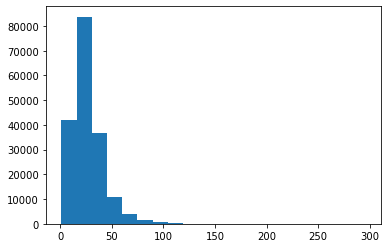

In [34]:
# Whats the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20);

In [35]:

# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [36]:
# Maximum sequence length is the training set
max(sent_lens)

296

## Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers

In [37]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000 

In [38]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [39]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [42]:
# Test out text vectorizer om random sentences

import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")



Text:
after appliance placement , all patients were periodically educated to the oral hygiene procedures .

Length of text: 15

Vectorized text:
[[   21  4726  1164    62    12     9 16767  8472     6     2   217  2619
    705     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [43]:

# How many words in our training vocabulary?

rct_20k_text_vocab = text_vectorizer.get_vocabulary() # Gets all the 68k words
print(f"Number od words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")


Number od words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [44]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False}

### Create custom text embedding

In [45]:
#Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim = 128,# Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=False,  # Use masking to handle variable sequence lengths (save space)[take the zeros or not]
                               name="token_embedding")



In [46]:
# Show example embedding
print(f"Sentence befor vectorization: \n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectoriation: (before embedding): \n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"sentence after embedding:\n {embedded_sentence}")

Sentence befor vectorization: 
 after appliance placement , all patients were periodically educated to the oral hygiene procedures .

Sentence after vectoriation: (before embedding): 
 [[   21  4726  1164    62    12     9 16767  8472     6     2   217  2619
    705     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
sentence after embedding:
 [[[-0.04283118 -0.00387961 -0.01455583 ...  0.04825513 -0.00789366
    0.00189775]
  [ 0.00955675 -0.01191317  0.00780604 ... -0.01638478 -0.02591658
    0.0444705 ]
  [ 0.04580184  0.00879665 -0.00942345 ... -0.02971577 -0.02701733
    0.02599433]
  ...
  [ 0.02408476  0.00877072  0.02966959 ...  0.02324628  0.01719328
   -0.01311161]
  [ 0.02408476  0.00877072  0.02966959 ...  0.02324628  0.01719328
   -0.01311161]
  [ 0.02408476  0.0087707

## Create datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the tensorflow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data
* https://www.tensorflow.org/guide/data_performance

In [47]:
# TUrn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [48]:
# Take the TensorSliceDataset's and turn them into prefetched Datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [49]:
# Creat 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embedding = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [51]:
# Fit the model
history_model_1= model_1.fit(train_dataset,
                             steps_per_epoch=int(0.1*len(train_dataset)), # only fit on 10% of batches for faster training time(562 instead of 5627(i.e 5800 that we set))
                             epochs=3,
                             validation_data=valid_dataset,
                             validation_steps=int(0.1*len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 88s 156ms/step - loss: 0.9200 - accuracy: 0.6353 - val_loss: 0.6903 - val_accuracy: 0.7380
Epoch 2/3
562/562 [==============================] - 86s 153ms/step - loss: 0.6614 - accuracy: 0.7547 - val_loss: 0.6324 - val_accuracy: 0.7676
Epoch 3/3
562/562 [==============================] - 88s 157ms/step - loss: 0.6212 - accuracy: 0.7715 - val_loss: 0.5988 - val_accuracy: 0.7842


In [52]:
#  Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.6025 - accuracy: 0.7840


[0.6025262475013733, 0.783993124961853]

In [53]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[3.8761851e-01, 1.9758269e-01, 8.6081967e-02, 2.9121268e-01,
        3.7504129e-02],
       [5.0267291e-01, 2.1838549e-01, 1.3992302e-02, 2.5831172e-01,
        6.6375672e-03],
       [1.3508326e-01, 6.6259056e-03, 1.8941907e-03, 8.5633433e-01,
        6.2400133e-05],
       ...,
       [1.6262543e-06, 4.5470477e-04, 4.6436756e-04, 1.9726738e-06,
        9.9907732e-01],
       [6.1252829e-02, 4.7542760e-01, 1.1595923e-01, 7.2276793e-02,
        2.7508351e-01],
       [1.5292081e-01, 6.9640863e-01, 3.7651952e-02, 3.9351862e-02,
        7.3666729e-02]], dtype=float32)

In [54]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [55]:
# calculate model_1 results
model_1_results = calculate_results(val_labels_encoded,model_1_preds)
model_1_results

{'accuracy': 78.39931153184165,
 'precision': 0.7803886669473357,
 'recall': 0.7839931153184165,
 'f1': 0.7813729849803397}

In [56]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from tensorflow hub, more specifically the universal sentence encoder:(USE): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used Glove embeddings, however, we're going going to stick with the later created USE pretrained embeddings.

In [58]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")


In [59]:
# Test out the pretrained embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
in patients who scored @ points or less in all scorings , intubation conditions were considered acceptable , however if any of the scores was greater than @ , intubation conditions were regarded unacceptable .

Sentence after embedding:
[-0.08068188 -0.00190032  0.02337556  0.02758141  0.05872887 -0.02905573
 -0.01498709 -0.0132398  -0.01699652  0.05631635  0.06265351 -0.00480677
 -0.00571957  0.06350227  0.01796289  0.00792038 -0.07877348  0.05257777
  0.00156379  0.00074525  0.07446788  0.00411085 -0.05672675  0.01485376
 -0.02498941 -0.00951734 -0.02817356  0.07803362 -0.0241541   0.03827016] (truncated output)...

Length of sentence embedding:
512


### Building and fitting an NLP feature extraction model from TensorFlow Hub using pretrained embeddings

In [60]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding)  # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x)  # create the output layer
model_2 = tf.keras.Model(inputs,
                         outputs, 
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [61]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [62]:
# Fit model_2 to the data

history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data = valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9156 - accuracy: 0.6511 - val_loss: 0.7947 - val_accuracy: 0.6912
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7661 - accuracy: 0.7031 - val_loss: 0.7523 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7480 - accuracy: 0.7144 - val_loss: 0.7362 - val_accuracy: 0.7128


In [63]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7376 - accuracy: 0.7157


[0.7376024723052979, 0.7157089710235596]

In [64]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.3716559e-01, 3.4355944e-01, 2.4361440e-03, 2.1068339e-01,
        6.1554406e-03],
       [3.4803304e-01, 4.9245331e-01, 4.3972847e-03, 1.5279035e-01,
        2.3259763e-03],
       [2.5468490e-01, 1.3765882e-01, 1.8597938e-02, 5.5413634e-01,
        3.4921966e-02],
       ...,
       [1.7355208e-03, 6.2870155e-03, 5.5199374e-02, 9.0668723e-04,
        9.3587148e-01],
       [4.4484404e-03, 4.5338266e-02, 1.9428274e-01, 1.4590293e-03,
        7.5447148e-01],
       [1.6555965e-01, 2.1437430e-01, 5.4760277e-01, 8.4202988e-03,
        6.4042985e-02]], dtype=float32)

In [65]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [66]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.57089898053754,
 'precision': 0.7160562889209549,
 'recall': 0.7157089898053753,
 'f1': 0.7127802294739073}

## Model 3: Conv1D with character embeddings

The paper which we are replicating states that they used a combination of token and character-level embeddings

Previously we used token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating character-level tokenizer

In [67]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [68]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))



In [69]:
list(train_sentences[0]) # List of train_sentences[0] will giv us the characters of the 1st sentence(list of string gives characters)

['t',
 'o',
 ' ',
 'i',
 'n',
 'v',
 'e',
 's',
 't',
 'i',
 'g',
 'a',
 't',
 'e',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'e',
 'f',
 'f',
 'i',
 'c',
 'a',
 'c',
 'y',
 ' ',
 'o',
 'f',
 ' ',
 '@',
 ' ',
 'w',
 'e',
 'e',
 'k',
 's',
 ' ',
 'o',
 'f',
 ' ',
 'd',
 'a',
 'i',
 'l',
 'y',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'd',
 'o',
 's',
 'e',
 ' ',
 'o',
 'r',
 'a',
 'l',
 ' ',
 'p',
 'r',
 'e',
 'd',
 'n',
 'i',
 's',
 'o',
 'l',
 'o',
 'n',
 'e',
 ' ',
 'i',
 'n',
 ' ',
 'i',
 'm',
 'p',
 'r',
 'o',
 'v',
 'i',
 'n',
 'g',
 ' ',
 'p',
 'a',
 'i',
 'n',
 ' ',
 ',',
 ' ',
 'm',
 'o',
 'b',
 'i',
 'l',
 'i',
 't',
 'y',
 ' ',
 ',',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 's',
 'y',
 's',
 't',
 'e',
 'm',
 'i',
 'c',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'g',
 'r',
 'a',
 'd',
 'e',
 ' ',
 'i',
 'n',
 'f',
 'l',
 'a',
 'm',
 'm',
 'a',
 't',
 'i',
 'o',
 'n',
 ' ',
 'i',
 'n',
 ' ',
 't',
 'h',
 'e',
 ' ',
 's',
 'h',
 'o',
 'r',
 't',
 ' ',
 't',
 'e',
 'r',
 'm',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'w',
 'h',
 'e'

In [70]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [71]:
# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'i n   p a t i e n t s   w h o   s c o r e d   @   p o i n t s   o r   l e s s   i n   a l l   s c o r i n g s   ,   i n t u b a t i o n   c o n d i t i o n s   w e r e   c o n s i d e r e d   a c c e p t a b l e   ,   h o w e v e r   i f   a n y   o f   t h e   s c o r e s   w a s   g r e a t e r   t h a n   @   ,   i n t u b a t i o n   c o n d i t i o n s   w e r e   r e g a r d e d   u n a c c e p t a b l e   .'

In [72]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [73]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

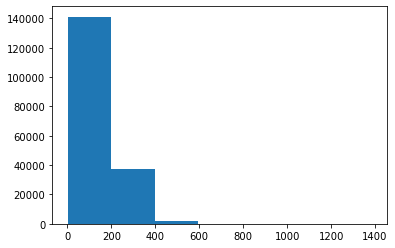

In [74]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [75]:

# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [76]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [77]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token(Out of vocabulary)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation", # set standardization to 'None' if you want to keep punctuation
                                    name="char_vectorizer")


In [78]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [79]:
# Char character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [80]:
# Test out character vectorizer

random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nvectorized chars: \n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t w o   h o u r s   a f t e r   t r e a t m e n t   ,   t h e   s y m p t o m s   b e t w e e n   t h e   g r o u p s   s h o w e d   n o   d i f f e r e n c e   i n   m e a s u r e s   o f   n a u s e a   (   p   =   @   )   o r   d i z z i n e s s   (   p   =   @   )   .
Length of random_train_chars: 108

vectorized chars: 
 [[ 3 20  7 13  7 16  8  9  5 17  3  2  8  3  8  2  5  3 15  2  6  3  3 13
   2  9 19 15 14  3  7 15  9 22  2  3 20  2  2  6  3 13  2 18  8  7 16 14
   9  9 13  7 20  2 10  6  7 10  4 17 17  2  8  2  6 11  2  4  6 15  2  5
   9 16  8  2  9  7 17  6  5 16  9  2  5 14  7  8 10  4 25 25  4  6  2  9
   9 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## Creating a character-level embedding

In [81]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),  # number of different characters
                              output_dim = 25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name='char_embed')


In [82]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t w o   h o u r s   a f t e r   t r e a t m e n t   ,   t h e   s y m p t o m s   b e t w e e n   t h e   g r o u p s   s h o w e d   n o   d i f f e r e n c e   i n   m e a s u r e s   o f   n a u s e a   (   p   =   @   )   o r   d i z z i n e s s   (   p   =   @   )   .

Embedded chars (after vectorization and embedding):
[[[-0.00467091  0.00628003  0.04586733 ... -0.0322768   0.03934177
    0.01216657]
  [-0.00671797  0.04997187 -0.02906092 ...  0.02658999  0.00814645
    0.03427922]
  [-0.023344   -0.0148584   0.01389381 ...  0.04507807  0.01872795
   -0.03685634]
  ...
  [-0.02807024 -0.0195931   0.00395532 ... -0.03011898 -0.04269482
   -0.02148722]
  [-0.02807024 -0.0195931   0.00395532 ... -0.03011898 -0.04269482
   -0.02148722]
  [-0.02807024 -0.0195931   0.00395532 ... -0.03011898 -0.04269482
   -0.02148722]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [83]:
# Make Conv1D on chars only
input = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [84]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
___________________________________

In [85]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [86]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 23ms/step - loss: 1.2771 - accuracy: 0.4711 - val_loss: 1.0842 - val_accuracy: 0.5645
Epoch 2/3
562/562 [==============================] - 12s 22ms/step - loss: 1.0404 - accuracy: 0.5842 - val_loss: 0.9808 - val_accuracy: 0.6074
Epoch 3/3
562/562 [==============================] - 12s 22ms/step - loss: 0.9591 - accuracy: 0.6219 - val_loss: 0.9054 - val_accuracy: 0.6523


In [87]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 7s 8ms/step - loss: 0.9215 - accuracy: 0.6407: 


[0.9215273261070251, 0.6407057046890259]

In [88]:
# Make predictions with character model only
model_3_pred_probs=model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.23093678, 0.31864288, 0.08925245, 0.33192608, 0.02924184],
       [0.15710756, 0.61202097, 0.0357081 , 0.14005673, 0.05510662],
       [0.13113311, 0.35683316, 0.26440406, 0.18060672, 0.06702292],
       ...,
       [0.03903359, 0.06499136, 0.13294525, 0.04319937, 0.71983045],
       [0.02284054, 0.09680077, 0.19324464, 0.04007216, 0.64704186],
       [0.5132434 , 0.38033295, 0.0305948 , 0.06303102, 0.01279782]],
      dtype=float32)

In [89]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)
model_3_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 4, 0], dtype=int64)>

In [90]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 64.07056798623064,
 'precision': 0.6310953631390267,
 'recall': 0.6407056798623064,
 'f1': 0.6296923709068605}

## Model 4: Combining pretrained token embeddings + character embeddings 

* Create a token-level model (similar to model_1)
* Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
* Combine (using layers.Concatenate) the outputs of 1 and 2
* Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf)
* Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [91]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs= token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")






In [92]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

In [93]:
# # Plot hybrid token and character model
from tensorflow.keras.utils import plot_model

plot_model(model_4, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [94]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a `tf.data` dataset

In [95]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [96]:

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

Understanding tf.data.Dataset.from_tensor_slices

In [97]:
x = tf.constant(np.random.randint(0,10, size=(2,3,10)))
y = tf.constant(np.random.randint(0,10, size=(2,5)))
print(x.shape)

dataset_fts = tf.data.Dataset.from_tensor_slices((x,y))
print(dataset_fts)
for _ in dataset_fts:
    print()
    print(_)

    # So basically the dimension "2"(first dimension generally the batch size gets combined)
    # (3,10) (5) and (3,10) (5)

(2, 3, 10)
<TensorSliceDataset shapes: ((3, 10), (5,)), types: (tf.int32, tf.int32)>

(<tf.Tensor: shape=(3, 10), dtype=int32, numpy=
array([[4, 9, 6, 0, 3, 9, 8, 4, 3, 6],
       [8, 4, 3, 2, 5, 5, 0, 1, 3, 7],
       [1, 7, 3, 2, 9, 6, 6, 3, 2, 4]])>, <tf.Tensor: shape=(5,), dtype=int32, numpy=array([4, 3, 3, 1, 7])>)

(<tf.Tensor: shape=(3, 10), dtype=int32, numpy=
array([[4, 6, 2, 8, 9, 0, 6, 8, 3, 0],
       [3, 7, 1, 6, 3, 4, 8, 4, 4, 6],
       [5, 3, 5, 8, 9, 2, 2, 2, 5, 6]])>, <tf.Tensor: shape=(5,), dtype=int32, numpy=array([9, 8, 5, 8, 3])>)


### Fitting a model on token and character-level sequences

In [98]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data= val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 96s 163ms/step - loss: 0.9837 - accuracy: 0.6078 - val_loss: 0.7873 - val_accuracy: 0.6968
Epoch 2/3
562/562 [==============================] - 86s 154ms/step - loss: 0.8096 - accuracy: 0.6908 - val_loss: 0.7223 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - 88s 157ms/step - loss: 0.7796 - accuracy: 0.7025 - val_loss: 0.6956 - val_accuracy: 0.7384


In [99]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 36s 38ms/step - loss: 0.6997 - accuracy: 0.73140s - loss: 0.6


[0.6996905207633972, 0.731431245803833]

In [100]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.4012836e-01, 3.3238903e-01, 5.0206888e-03, 2.1594033e-01,
        6.5215761e-03],
       [2.8811172e-01, 5.6679398e-01, 2.8508534e-03, 1.4048672e-01,
        1.7567034e-03],
       [2.8411865e-01, 1.2295221e-01, 4.4314865e-02, 5.1670474e-01,
        3.1909548e-02],
       ...,
       [3.6423584e-04, 6.8955543e-03, 2.5080340e-02, 2.0403252e-04,
        9.6745580e-01],
       [7.4332561e-03, 6.2423356e-02, 1.7691566e-01, 3.8366714e-03,
        7.4939108e-01],
       [3.0140927e-01, 3.1565496e-01, 2.7053347e-01, 4.0080309e-02,
        7.2321936e-02]], dtype=float32)

In [101]:

# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1], dtype=int64)>

In [102]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.14312193830266,
 'precision': 0.7330680347614803,
 'recall': 0.7314312193830266,
 'f1': 0.7282314208742288}

In [103]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [104]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


**Note**: Any engineered features used to train a model need to be available at test time. In our case, line numbers and total time are available.

### Create positional embeddings

In [105]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

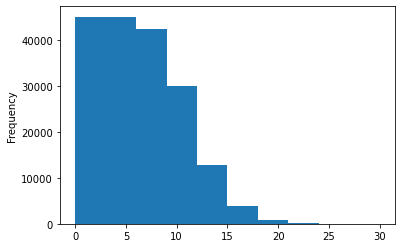

In [106]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [107]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature, lets do the same for our total lines feature..

In [108]:
# How many different numbers of lines are there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

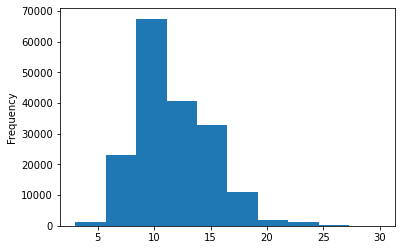

In [109]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();


In [110]:
# Check the coverage of a 'totat_lines' value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [111]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.Model`

In [112]:

# 1. Token inputs

token_inputs = layers.Input(shape=[], dtype = "string", name = 'token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation= 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name = "line_number_input") # shape is 15 because train_line_numbers_one_hot[0].shape
x= layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input") # shape is 20 because of train_total_lines_one_hot[0].shape
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z=layers.Dropout(0.5)(z)


# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
tribrid_embeddings = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                                total_line_model.output,
                                                                                z])

# 7. Create output layer
output_layer= layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)


# 8. Put together model

model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer,
                         name="tribrid_embedding_model")



In [113]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________________

In [114]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

what label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 1.96, 0.01, 0.01]`

for more on label smoothing see this: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/


In [115]:
# Combine token,char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting - add label smoothing (examples which are really confident get smoothed a little)
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets and fit tribrid model

In [116]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars


train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, # line numbers
                                                                val_total_lines_one_hot, # total lines
                                                                val_sentences, # train tokens
                                                                val_chars)) # train chars


val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # train labels
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels)) # combine data and labels
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [117]:
# Fit the token, char and positional embedding model

model_5_history = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data = val_pos_char_token_dataset,
                              validation_steps=int(0.1*len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 101s 171ms/step - loss: 1.0981 - accuracy: 0.7188 - val_loss: 0.9848 - val_accuracy: 0.8055
Epoch 2/3
562/562 [==============================] - 94s 167ms/step - loss: 0.9715 - accuracy: 0.8138 - val_loss: 0.9537 - val_accuracy: 0.8198
Epoch 3/3
562/562 [==============================] - 103s 183ms/step - loss: 0.9555 - accuracy: 0.8199 - val_loss: 0.9392 - val_accuracy: 0.8298


In [118]:
# Make predictions with token-char-positional hybrid model

model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 44s 44ms/step


array([[0.53330266, 0.10463977, 0.0125126 , 0.3296364 , 0.01990859],
       [0.587078  , 0.09288283, 0.04248013, 0.26786083, 0.00969817],
       [0.2474112 , 0.12727763, 0.15043357, 0.4052627 , 0.0696149 ],
       ...,
       [0.03865271, 0.10332576, 0.03970177, 0.03194585, 0.786374  ],
       [0.02835066, 0.2526036 , 0.07603782, 0.02480187, 0.6182061 ],
       [0.24843569, 0.5585397 , 0.09546428, 0.04307275, 0.0544876 ]],
      dtype=float32)

In [119]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [120]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.30795710313782,
 'precision': 0.8320391184450099,
 'recall': 0.8330795710313783,
 'f1': 0.8318530126074698}

In [121]:
model_4_results

{'accuracy': 73.14312193830266,
 'precision': 0.7330680347614803,
 'recall': 0.7314312193830266,
 'f1': 0.7282314208742288}

## Compare model results

In [122]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.399312,0.780389,0.783993,0.781373
pretrained_token_embed,71.570899,0.716056,0.715709,0.712780
custom_char_embed_conv1d,64.070568,0.631095,0.640706,0.629692
hybrid_char_token_embed,73.143122,0.733068,0.731431,0.728231
tribrid_pos_char_token_embed,83.307957,0.832039,0.833080,0.831853


In [123]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100

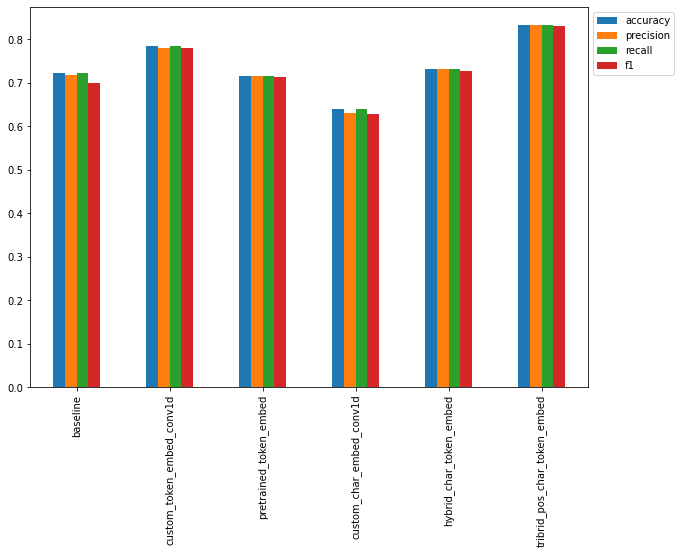

In [124]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

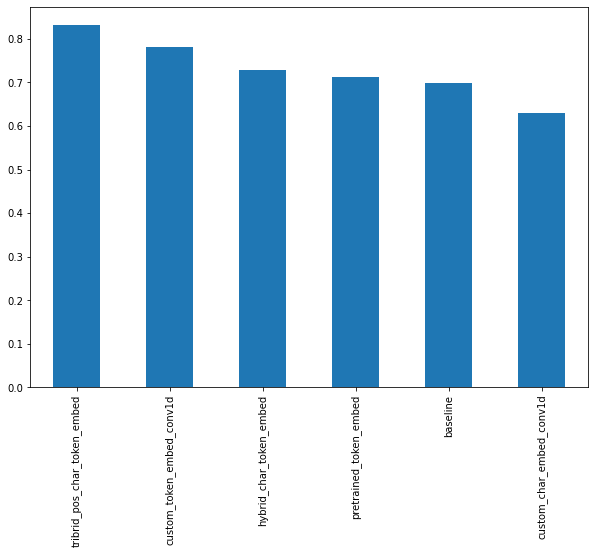

In [125]:
# Sort model results by f1-score

all_model_results.sort_values('f1', ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

### Save and load best performing model

In [126]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


In [127]:
# Load in the best pperforming model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [128]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1], dtype=int64)>

In [129]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)

loaded_model_results

{'accuracy': 83.20203892493049,
 'precision': 0.8305690283766348,
 'recall': 0.8320203892493049,
 'f1': 0.8307472187737373}

In [130]:
model_5_results

{'accuracy': 83.30795710313782,
 'precision': 0.8320391184450099,
 'recall': 0.8330795710313783,
 'f1': 0.8318530126074698}